In [1]:
# ==============================================================================
# PROJET : ÉTUDE DE SANTÉ PUBLIQUE (FAO)
# Analyste : [Votre Nom]
# Objectif : Analyser la sécurité alimentaire mondiale via les données FAOSTAT
# ==============================================================================

# ------------------------------------------------------------------------------
# 1. CONFIGURATION ET CHARGEMENT
# ------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration esthétique
sns.set_theme(style="whitegrid")
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
def load_and_summarize(path):
    """Charge un CSV et affiche un résumé rapide."""
    df = pd.read_csv(path)
    print(f"--- Fichier : {path} ---")
    print(f"Dimensions : {df.shape}")
    return df

In [3]:
# Chargement des fichiers
pop = load_and_summarize('population.csv')
dispo = load_and_summarize('dispo_alimentaire.csv')
aide = load_and_summarize('aide_alimentaire.csv')
sous_nut = load_and_summarize('sous_nutrition.csv')


--- Fichier : population.csv ---
Dimensions : (1416, 3)
--- Fichier : dispo_alimentaire.csv ---
Dimensions : (15605, 18)
--- Fichier : aide_alimentaire.csv ---
Dimensions : (1475, 4)
--- Fichier : sous_nutrition.csv ---
Dimensions : (1218, 3)


In [4]:
# ------------------------------------------------------------------------------
# 2. NETTOYAGE ET PRÉPARATION (DATA WRANGLING)
# ------------------------------------------------------------------------------

# 2.1 Population : Conversion en unités réelles
pop['Valeur'] *= 1000
pop.rename(columns={'Valeur': 'population', 'Zone': 'pays'}, inplace=True)
# 2.2 Sous-nutrition : Nettoyage et conversion
# Transformation de "2016-2018" en l'année centrale 2017 pour la jointure
sous_nut['Année'] = sous_nut['Année'].str.extract('(\d{4})').astype(int) + 1
# Gestion des valeurs '<0.1' (estimées à 0.05 pour calcul) et conversion en millions
sous_nut['Valeur'] = pd.to_numeric(sous_nut['Valeur'].replace('<0.1', 0.0), errors='coerce').fillna(0)
sous_nut['Valeur'] *= 1000000
sous_nut.rename(columns={'Valeur': 'nb_sous_nut', 'Zone': 'pays'}, inplace=True)

# 2.3 Disponibilité : Remplissage des valeurs manquantes par 0
dispo.fillna(0, inplace=True)
dispo.rename(columns={'Zone': 'pays'}, inplace=True)


In [5]:
# ------------------------------------------------------------------------------
# 3. ANALYSES POUR L'ANNÉE 2017
# ------------------------------------------------------------------------------

# Isolation des données 2017
pop_2017 = pop[pop['Année'] == 2017][['pays', 'population']]
sn_2017 = sous_nut[sous_nut['Année'] == 2017][['pays', 'nb_sous_nut']]

# Jointure pour le calcul de la proportion
df_global_2017 = pd.merge(pop_2017, sn_2017, on='pays', how='inner')

# Q1: Proportion de personnes en sous-nutrition
total_pop = df_global_2017['population'].sum()
total_sn = df_global_2017['nb_sous_nut'].sum()
print(f"\n--- BILAN MONDIAL 2017 ---")
print(f"Population totale : {total_pop/1e9:.2f} milliards")
print(f"Nombre de personnes en sous-nutrition : {total_sn/1e6:.1f} millions")
print(f"Proportion mondiale : {(total_sn/total_pop)*100:.2f}%")



--- BILAN MONDIAL 2017 ---
Population totale : 7.54 milliards
Nombre de personnes en sous-nutrition : 535.7 millions
Proportion mondiale : 7.10%


In [6]:
# ------------------------------------------------------------------------------
# 4. CAPACITÉ THÉORIQUE DE NOURRITURE
# ------------------------------------------------------------------------------

# Calcul de la disponibilité totale par pays (Kcal/jour)
dispo_pays = dispo.groupby('pays')['Disponibilité alimentaire (Kcal/personne/jour)'].sum().reset_index()
df_capa = pd.merge(dispo_pays, pop_2017, on='pays')
df_capa['dispo_kcal_totale_jour'] = df_capa['Disponibilité alimentaire (Kcal/personne/jour)'] * df_capa['population']

# Q2: Capacité totale (tous produits) vs Besoin (2500 kcal/jour)
capa_totale = df_capa['dispo_kcal_totale_jour'].sum() / 2500
print(f"\nLa production mondiale pourrait nourrir {capa_totale/1e9:.2f} milliards d'humains.")

# Q3: Capacité (produits végétaux uniquement)
veg_list = dispo[dispo['Origine'] == 'vegetale'].groupby('pays')['Disponibilité alimentaire (Kcal/personne/jour)'].sum().reset_index()
df_veg = pd.merge(veg_list, pop_2017, on='pays')
capa_veg = (df_veg['Disponibilité alimentaire (Kcal/personne/jour)'] * df_veg['population']).sum() / 2500
print(f"La production végétale seule pourrait nourrir {capa_veg/1e9:.2f} milliards d'humains.")



La production mondiale pourrait nourrir 8.37 milliards d'humains.
La production végétale seule pourrait nourrir 6.90 milliards d'humains.


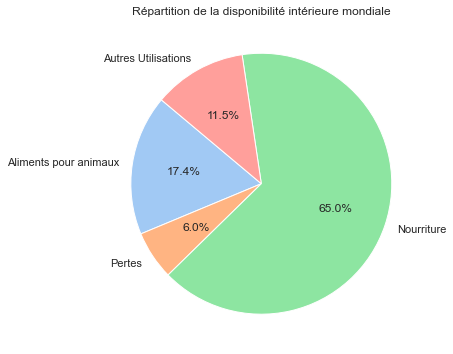

In [7]:
# ------------------------------------------------------------------------------
# 5. UTILISATION DE LA DISPONIBILITÉ (Pertes, Animaux, Alimentation)
# ------------------------------------------------------------------------------

# Q4: Répartition de la disponibilité intérieure
labels = ['Aliments pour animaux', 'Pertes', 'Nourriture', 'Autres Utilisations']
values = [dispo[col].sum() for col in ['Aliments pour animaux', 'Pertes', 'Nourriture', 'Autres Utilisations']]

plt.figure(figsize=(10, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title("Répartition de la disponibilité intérieure mondiale")
plt.show()



--- TOP 10 PAYS EN SOUS-NUTRITION (2017) ---
                                           pays  proportion_%
78                                        Haïti         48.26
157  République populaire démocratique de Corée         47.19
108                                  Madagascar         41.06
103                                     Libéria         38.28
100                                     Lesotho         38.25
183                                       Tchad         37.96
161                                      Rwanda         35.06
121                                  Mozambique         32.81
186                                 Timor-Leste         32.17
0                                   Afghanistan         28.93


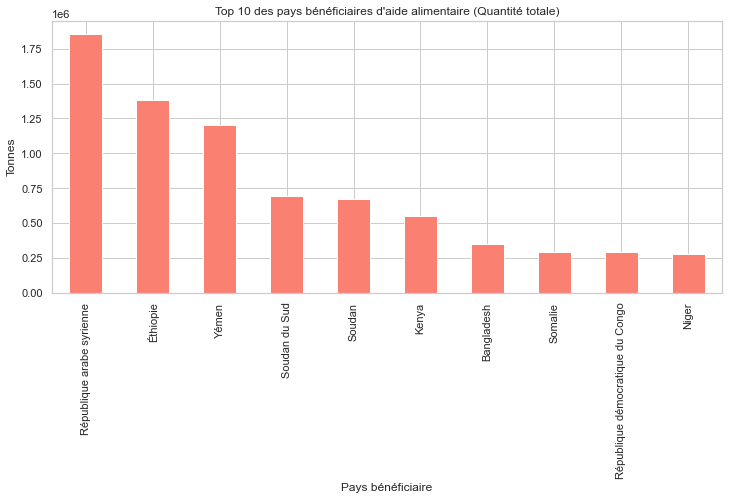

In [8]:
# ------------------------------------------------------------------------------
# 6. FOCUS PAYS : EXEMPLES CIBLÉS
# ------------------------------------------------------------------------------

# Pays avec la plus forte proportion de sous-nutrition
df_global_2017['proportion_%'] = (df_global_2017['nb_sous_nut'] / df_global_2017['population']) * 100
top_sn = df_global_2017.sort_values(by='proportion_%', ascending=False).head(10)

print("\n--- TOP 10 PAYS EN SOUS-NUTRITION (2017) ---")
print(top_sn[['pays', 'proportion_%']])

# Pays ayant reçu le plus d'aide depuis 2013
top_aide = aide.groupby('Pays bénéficiaire')['Valeur'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 5))
top_aide.plot(kind='bar', color='salmon')
plt.title("Top 10 des pays bénéficiaires d'aide alimentaire (Quantité totale)")
plt.ylabel("Tonnes")
plt.show()

In [9]:
# ------------------------------------------------------------------------------
# 7. EXPORTATION VERS CSV (Pour Reporting)
# ------------------------------------------------------------------------------
# df_global_2017.to_csv('resultats_fao_2017.csv', index=False)